In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py
from scipy import stats

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# one of input tsv path
input_tsv_bg = "./../ctcf_tsv/all_motifs_boundary.tsv"
input_tsv = "./../ctcf_tsv/filtered_base_mouse_ctcf.tsv"

numpy_arrays_dict = {"1": {"boSCD": "./../data/m1_boundary_scores.npy"  , 
                                 "cross": "./../data/m1_dot_scores_cross.npy", 
                                 "dot": "./../data/m1_dot_scores_dot.npy", 
                                 "dotSCD": "./../data/m1_dot_scores_SCD.npy", 
                                 "x": "./../data/m1_dot_scores_x.npy"},
                    "2": {"boSCD": "./../data/m2_boundary_scores.npy"  , 
                                 "cross": "./../data/m2_dot_scores_cross.npy", 
                                 "dot": "./../data/m2_dot_scores_dot.npy", 
                                 "dotSCD": "./../data/m2_dot_scores_SCD.npy", 
                                 "x": "./../data/m2_dot_scores_x.npy"}}


In [3]:
# reading tsv with bg column and dropping columns not needed for the summary step
df = pd.read_table(input_tsv_bg, sep="\t")
df = df.drop(columns=["orientation", "flank_bp", "spacer_bp"])

In [4]:
df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,background_index,exp_id
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0,0,0
1,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,1,0,1
2,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,2,0,2
3,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,3,0,3
4,1,chr1,4780000,7,10,4773435-4773454,4770000,+,4773435,4773454,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75055,4472,chr19,59390000,26376,10,59388426-59388445,59380000,+,59388426,59388445,7501,9,75055
75056,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,7502,9,75056
75057,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,7503,9,75057
75058,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,7504,9,75058


In [5]:
# basic parameters
nr_targets = 6
nr_backgrounds = 10
nr_sites = int(len(df) / nr_backgrounds)

# Adding scores and averaging over targets

In [6]:
def add_score_info(df, numpy_path, model_index, score_abb, nr_targets = 6):

    array = np.load(numpy_path)

    # adding score for each target

    for target_index in range(nr_targets):

        df[f"{score_abb}_m{model_index}_t{target_index}"] = array[:, target_index]

    # caclulating average over targets
    df[f"{score_abb}_m{model_index}_avg"] = df[[f"{score_abb}_m{model_index}_t{target_index}" for target_index in range(nr_targets)]].mean(axis=1)

    return df
    

In [7]:
for model in numpy_arrays_dict:
    print("Adding scores for model", model)
    for score in numpy_arrays_dict[model]:
        path = numpy_arrays_dict[model][score]
        df = add_score_info(df, path, model_index=int(model), score_abb=score)

Adding scores for model 1
Adding scores for model 2


In [8]:
df.columns

Index(['boundary_index', 'chrom', 'boundary_end', 'index', 'num_ctcf', 'span',
       'boundary_start', 'strand', 'start', 'end', 'seq_id',
       'background_index', 'exp_id', 'boSCD_m1_t0', 'boSCD_m1_t1',
       'boSCD_m1_t2', 'boSCD_m1_t3', 'boSCD_m1_t4', 'boSCD_m1_t5',
       'boSCD_m1_avg', 'cross_m1_t0', 'cross_m1_t1', 'cross_m1_t2',
       'cross_m1_t3', 'cross_m1_t4', 'cross_m1_t5', 'cross_m1_avg',
       'dot_m1_t0', 'dot_m1_t1', 'dot_m1_t2', 'dot_m1_t3', 'dot_m1_t4',
       'dot_m1_t5', 'dot_m1_avg', 'dotSCD_m1_t0', 'dotSCD_m1_t1',
       'dotSCD_m1_t2', 'dotSCD_m1_t3', 'dotSCD_m1_t4', 'dotSCD_m1_t5',
       'dotSCD_m1_avg', 'x_m1_t0', 'x_m1_t1', 'x_m1_t2', 'x_m1_t3', 'x_m1_t4',
       'x_m1_t5', 'x_m1_avg', 'boSCD_m2_t0', 'boSCD_m2_t1', 'boSCD_m2_t2',
       'boSCD_m2_t3', 'boSCD_m2_t4', 'boSCD_m2_t5', 'boSCD_m2_avg',
       'cross_m2_t0', 'cross_m2_t1', 'cross_m2_t2', 'cross_m2_t3',
       'cross_m2_t4', 'cross_m2_t5', 'cross_m2_avg', 'dot_m2_t0', 'dot_m2_t1',
       'dot_m

# Averaging over backgrounds

In [9]:
# reading tsv with all sites
summary_df = pd.read_table(input_tsv, sep="\t")

In [10]:
background_indices = list(df.background_index.unique())

In [11]:
for model in numpy_arrays_dict:
    print("Averaging over backgrounds for model", model)
    
    for score in numpy_arrays_dict[model]:
        summary_score_array = np.zeros((nr_sites, ))
        score_column = f"{score}_m{model}_avg"
        print("\t-", score_column)
        
        for background_i in background_indices:
            summary_score_array += np.array(df[df["background_index"] == background_i][score_column])

        summary_df[score_column] = summary_score_array / len(background_indices)
        

Averaging over backgrounds for model 1
	- boSCD_m1_avg
	- cross_m1_avg
	- dot_m1_avg
	- dotSCD_m1_avg
	- x_m1_avg
Averaging over backgrounds for model 2
	- boSCD_m2_avg
	- cross_m2_avg
	- dot_m2_avg
	- dotSCD_m2_avg
	- x_m2_avg


In [12]:
summary_df.columns

Index(['boundary_index', 'chrom', 'boundary_end', 'index', 'num_ctcf', 'span',
       'boundary_start', 'strand', 'start', 'end', 'boSCD_m1_avg',
       'cross_m1_avg', 'dot_m1_avg', 'dotSCD_m1_avg', 'x_m1_avg',
       'boSCD_m2_avg', 'cross_m2_avg', 'dot_m2_avg', 'dotSCD_m2_avg',
       'x_m2_avg'],
      dtype='object')

# Averaging over models

In [13]:
model_indices = [1, 2]

In [14]:
for score in numpy_arrays_dict[str(model_indices[0])]:
    ave_column_name = f"{score}_avg"
    columns_to_ave = [f"{score}_m{model_index}_avg" for model_index in model_indices]
    summary_df[ave_column_name] = summary_df[columns_to_ave].mean(axis=1)

In [92]:
summary_df["seq_id"] = [i for i in range(len(summary_df))]

In [93]:
summary_df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,...,cross_m2_avg,dot_m2_avg,dotSCD_m2_avg,x_m2_avg,boSCD_avg,cross_avg,dot_avg,dotSCD_avg,x_avg,seq_id
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,...,-0.000032,0.092943,7.766934,-0.000763,9.037672,-0.000050,0.117296,9.266314,-0.000590,0
1,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,...,0.557165,9.037897,49.880733,0.744777,52.070436,0.585809,9.712861,53.672213,0.791970,1
2,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,...,0.000389,0.122576,7.065542,0.000477,8.616976,0.000274,0.141602,8.613797,0.000151,2
3,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,...,0.000371,0.122317,7.068532,0.000480,8.619759,0.000278,0.141643,8.616264,0.000173,3
4,1,chr1,4780000,7,10,4773435-4773454,4770000,+,4773435,4773454,...,0.000174,0.118977,7.075237,0.000198,8.624807,0.000125,0.138779,8.622326,-0.000030,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501,4472,chr19,59390000,26376,10,59388426-59388445,59380000,+,59388426,59388445,...,0.000525,0.124052,7.058236,0.000649,8.617259,0.000393,0.142625,8.614886,0.000313,7501
7502,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,...,0.000204,0.117759,7.072621,0.000125,8.629315,0.000182,0.138199,8.625043,-0.000001,7502
7503,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,...,0.347622,5.366391,40.865839,0.455636,40.571769,0.353862,5.599413,43.088609,0.467975,7503
7504,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,...,0.000380,0.121089,7.071702,0.000473,8.609611,0.000271,0.140718,8.613583,0.000178,7504


In [94]:
# saving tsv with calculated and avergaed scores
summary_df.to_csv("./../ctcf_tsv/filtered_base_mouse_ctcf_scores.tsv", sep = "\t", index=False)

# Plots (scores are averaged over targets, models, and backgrounds)

## A) Correlation between boundary SCD and dot SCD

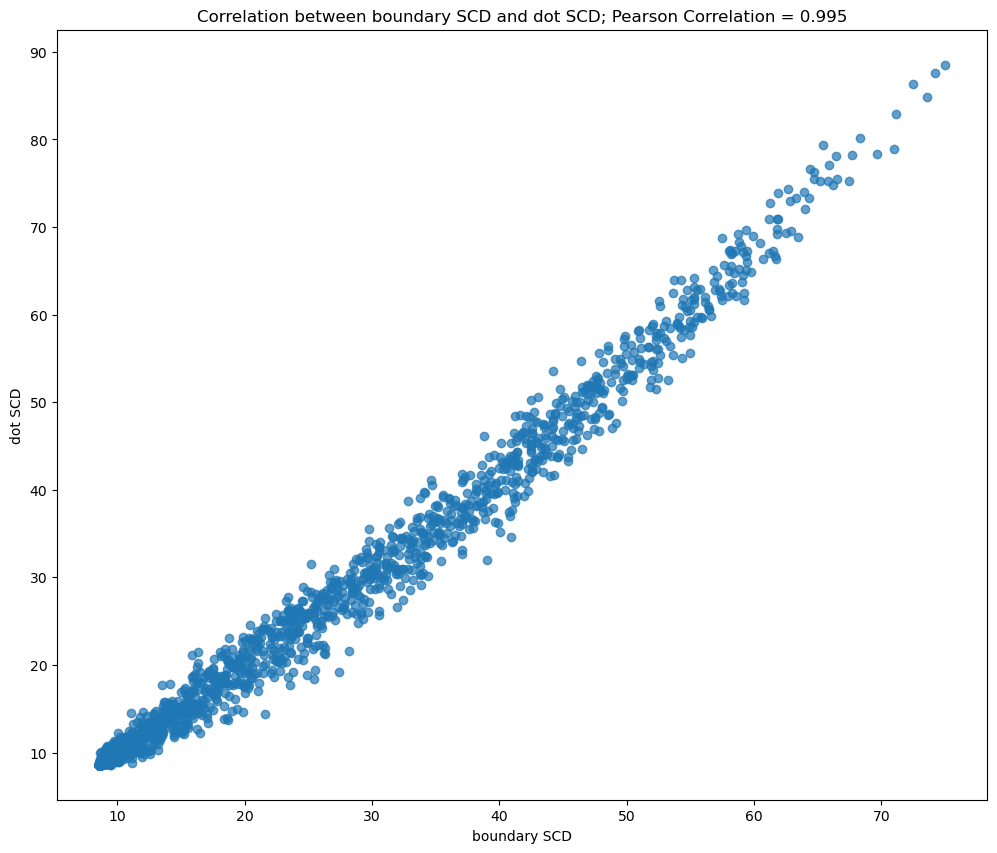

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["boSCD_avg"], summary_df["dotSCD_avg"], alpha=0.7)

pearson_corr = stats.pearsonr(summary_df["boSCD_avg"], summary_df["dotSCD_avg"]).statistic
rounded_pearson_corr = round(pearson_corr, 3)

ax.set_xlabel("boundary SCD")
ax.set_ylabel("dot SCD")

ax.set_title(f"Correlation between boundary SCD and dot SCD; Pearson Correlation = {rounded_pearson_corr}")

# plt.savefig("./plots/boundarySCD_vs_dotSCD.png", bbox_inches="tight")

plt.show()

## B) Boundary-SCD vs. cross-score

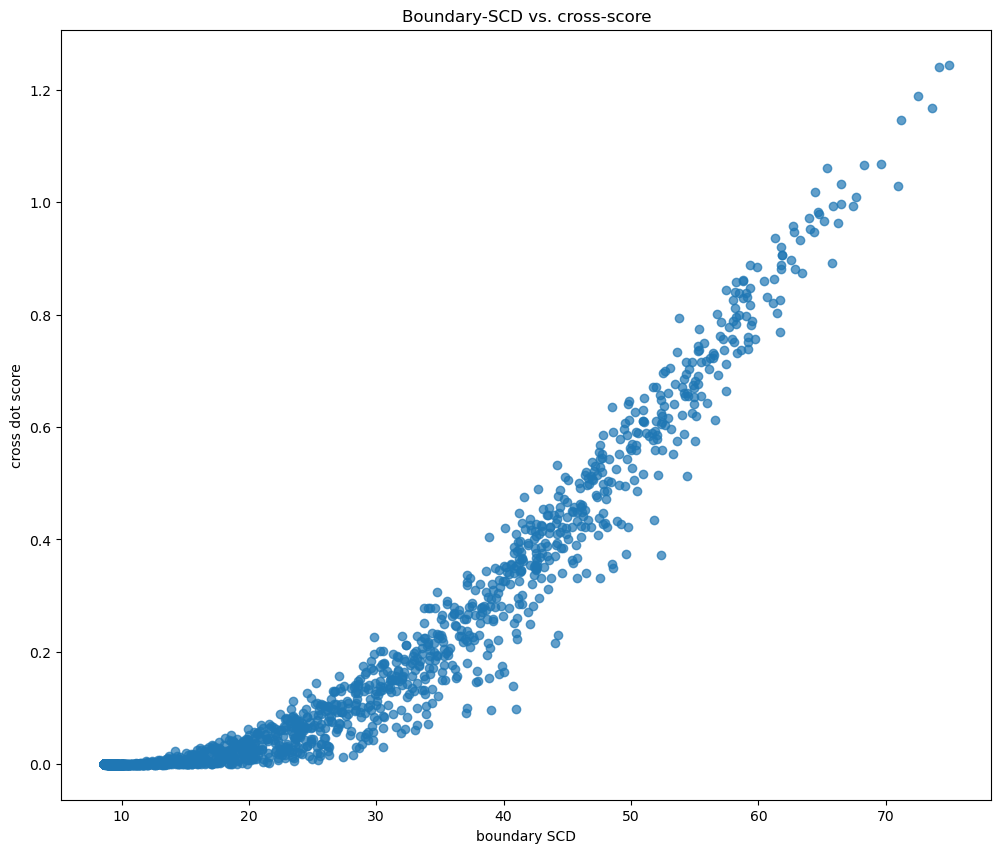

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["boSCD_avg"], summary_df["cross_avg"], alpha=0.7)

ax.set_xlabel("boundary SCD")
ax.set_ylabel("cross dot score")

ax.set_title("Boundary-SCD vs. cross-score")

# plt.savefig("./plots/boundarySCD_vs_cross-score.png", bbox_inches="tight")

plt.show()

## C) Boundary-SCD vs. dot-score

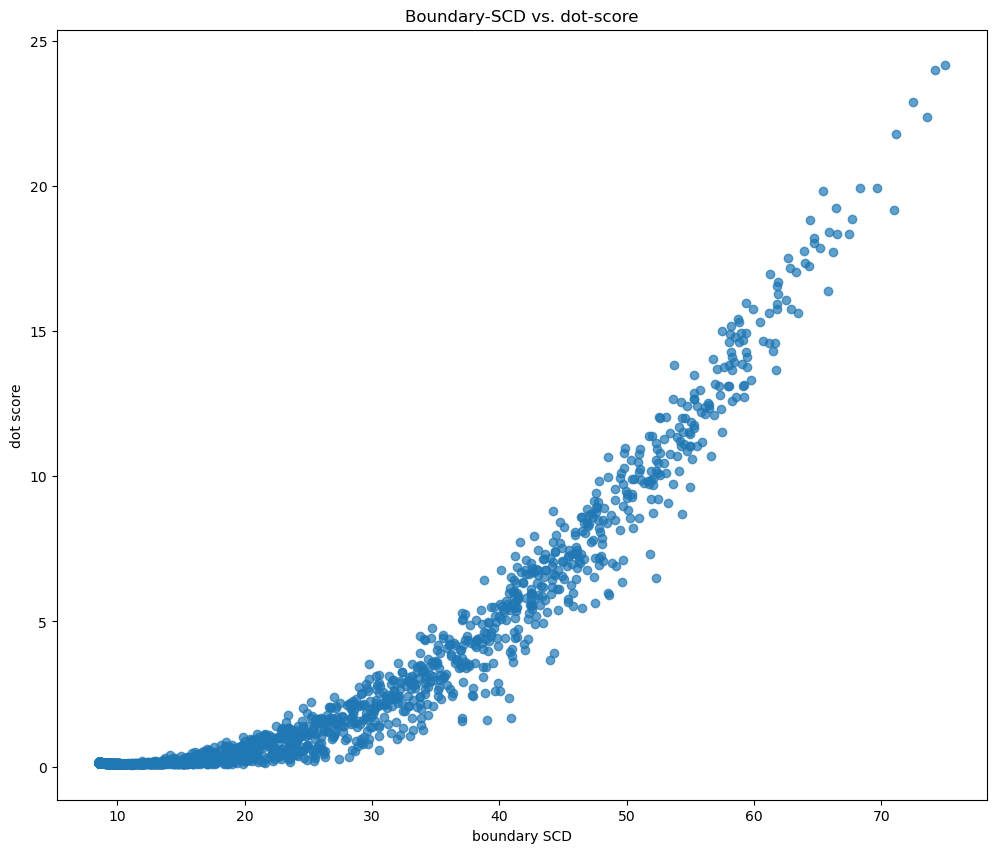

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["boSCD_avg"], summary_df["dot_avg"], alpha=0.7)

ax.set_xlabel("boundary SCD")
ax.set_ylabel("dot score")

ax.set_title("Boundary-SCD vs. dot-score")

# plt.savefig("./plots/boundarySCD_vs_dot-score.png", bbox_inches="tight")

plt.show()

## D) Boundary-SCD vs. x-score

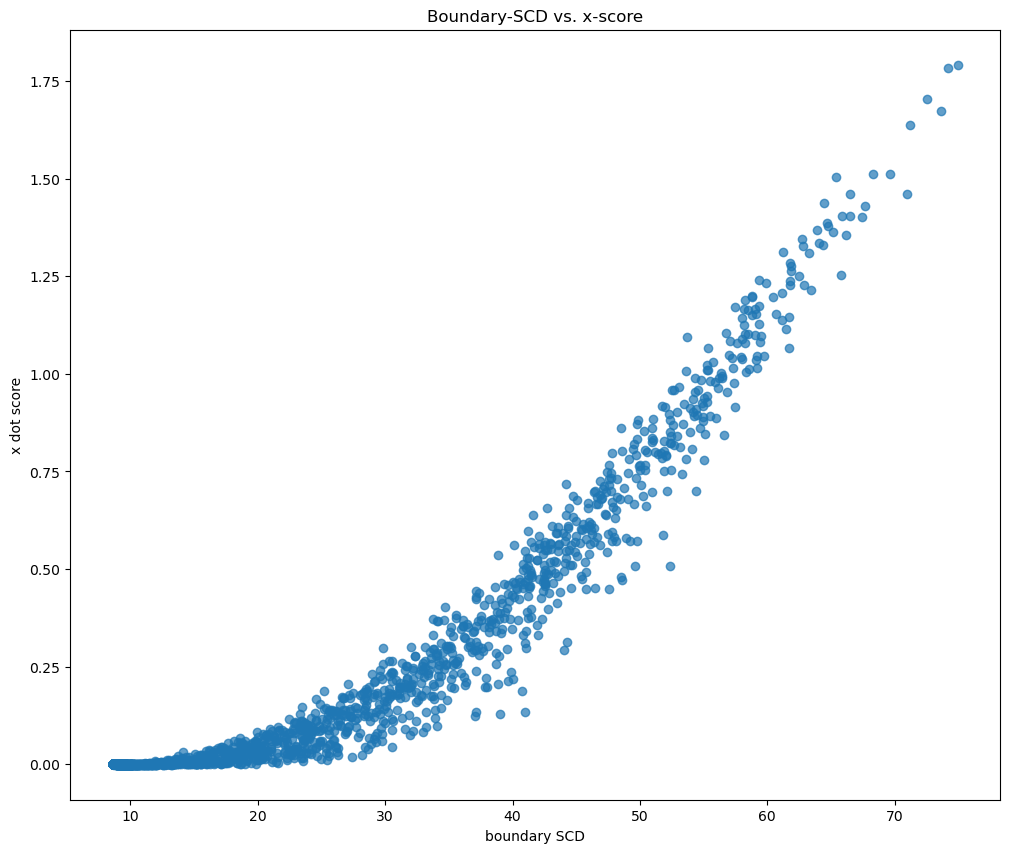

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["boSCD_avg"], summary_df["x_avg"], alpha=0.7)

ax.set_xlabel("boundary SCD")
ax.set_ylabel("x dot score")

ax.set_title("Boundary-SCD vs. x-score")

# plt.savefig("./plots/boundarySCD_vs_x-score.png", bbox_inches="tight")

plt.show()

# Scatterplot with histograms on the margins

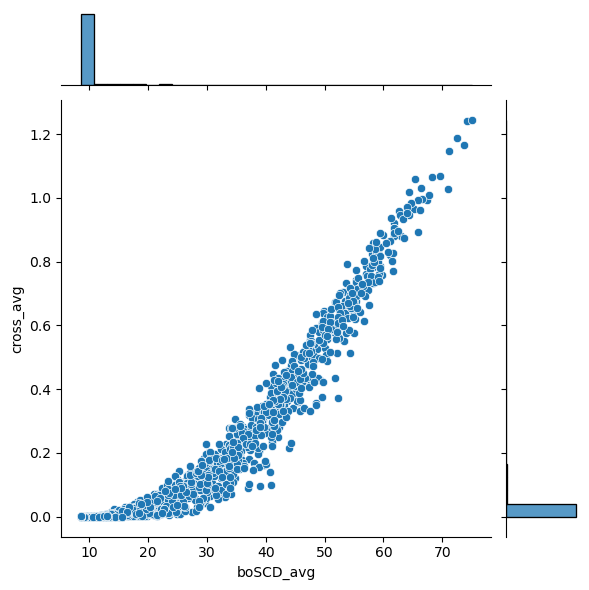

In [30]:
# sns.jointplot(x=summary_df["boSCD_avg"], y=summary_df["cross_avg"])

sns.jointplot(
    x=summary_df["boSCD_avg"], y=summary_df["cross_avg"], marginal_kws=dict(bins=30, fill=True),
)


### Let's plot histograms separately

<AxesSubplot:xlabel='cross_avg', ylabel='Count'>

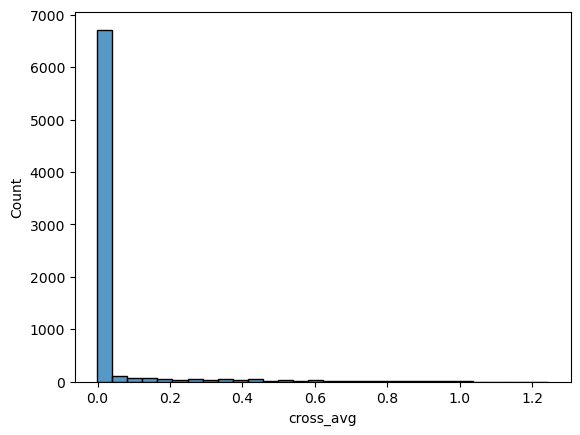

In [31]:
sns.histplot(x=summary_df["cross_avg"], bins=30)

<AxesSubplot:xlabel='boSCD_avg', ylabel='Count'>

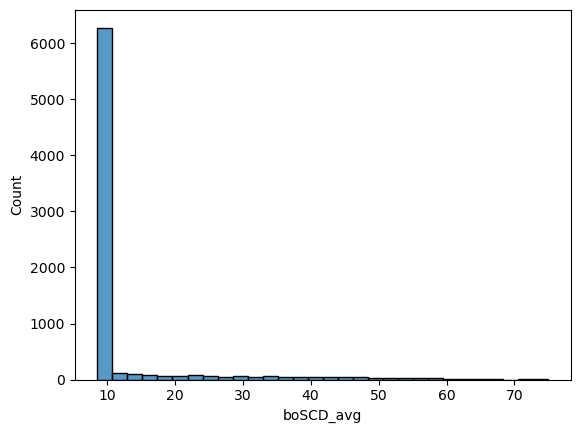

In [32]:
sns.histplot(x=summary_df["boSCD_avg"], bins=30)

# Correlations between models for all scores

## Cross-score

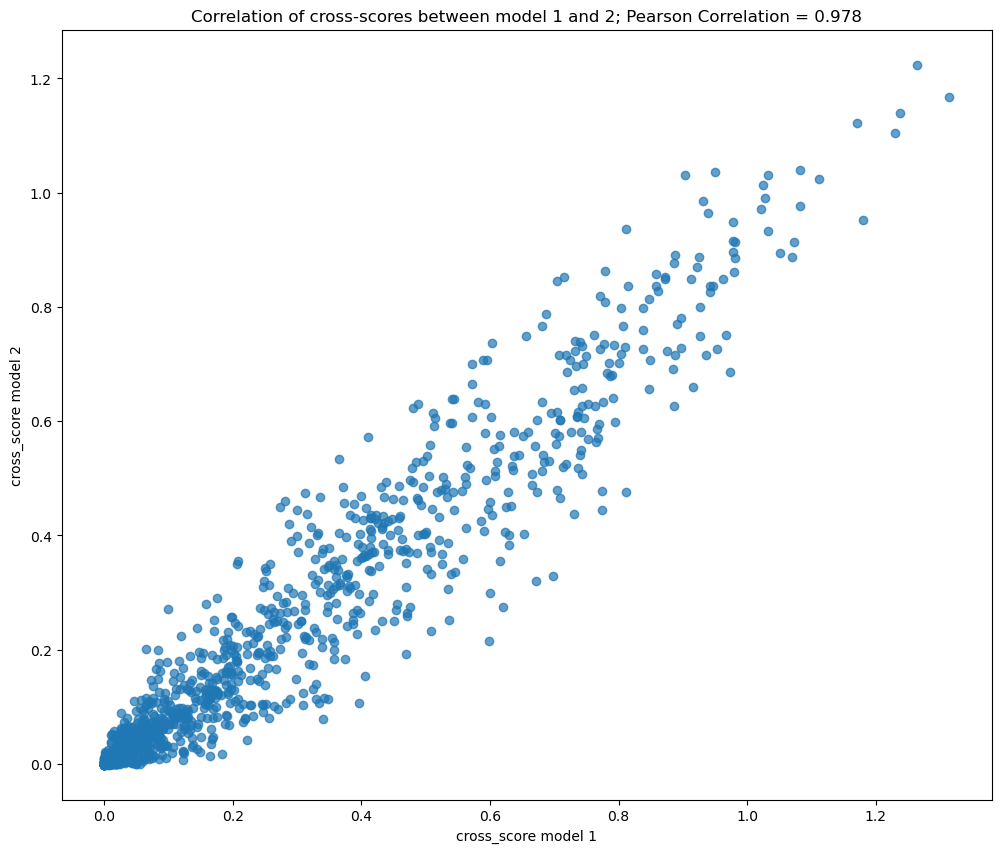

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["cross_m1_avg"], summary_df["cross_m2_avg"], alpha=0.7)

pearson_corr = stats.pearsonr(summary_df["cross_m1_avg"], summary_df["cross_m2_avg"]).statistic
rounded_pearson_corr = round(pearson_corr, 3)

ax.set_xlabel("cross_score model 1")
ax.set_ylabel("cross_score model 2")

ax.set_title(f"Correlation of cross-scores between model 1 and 2; Pearson Correlation = {rounded_pearson_corr}")

# plt.savefig("./plots/cross_score_corr_between_models.png", bbox_inches="tight")

plt.show()

## Dot-score

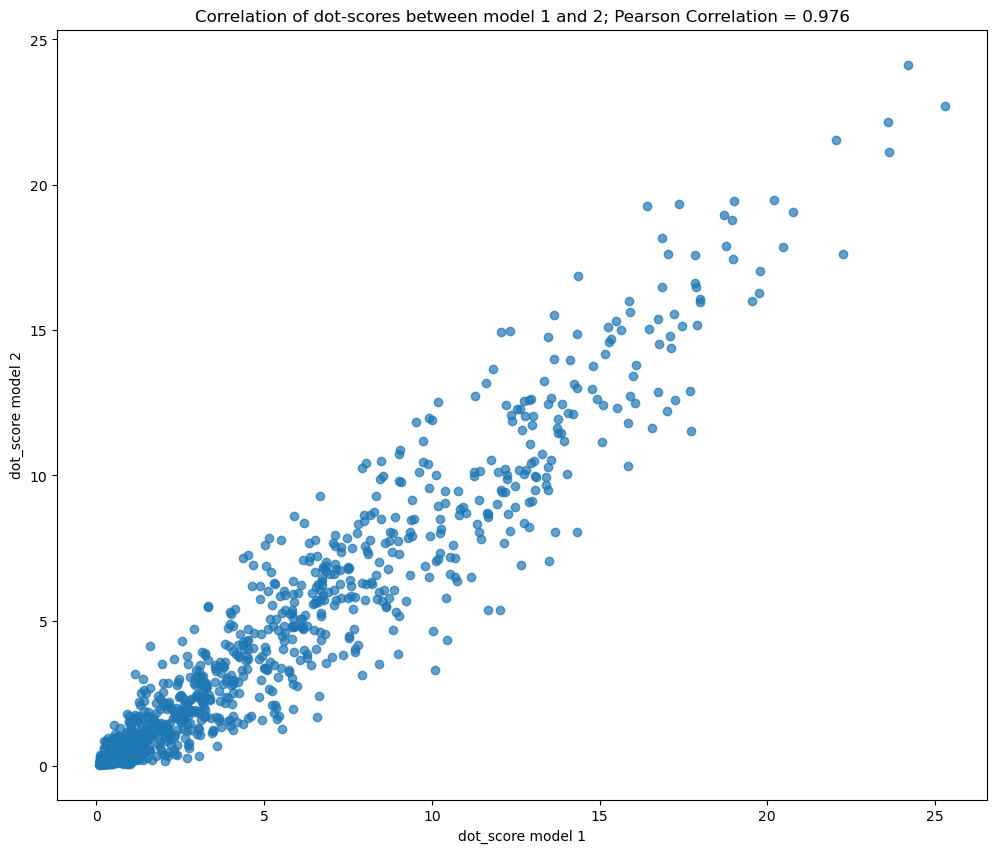

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["dot_m1_avg"], summary_df["dot_m2_avg"], alpha=0.7)

pearson_corr = stats.pearsonr(summary_df["dot_m1_avg"], summary_df["dot_m2_avg"]).statistic
rounded_pearson_corr = round(pearson_corr, 3)

ax.set_xlabel("dot_score model 1")
ax.set_ylabel("dot_score model 2")

ax.set_title(f"Correlation of dot-scores between model 1 and 2; Pearson Correlation = {rounded_pearson_corr}")

plt.show()

## x-score

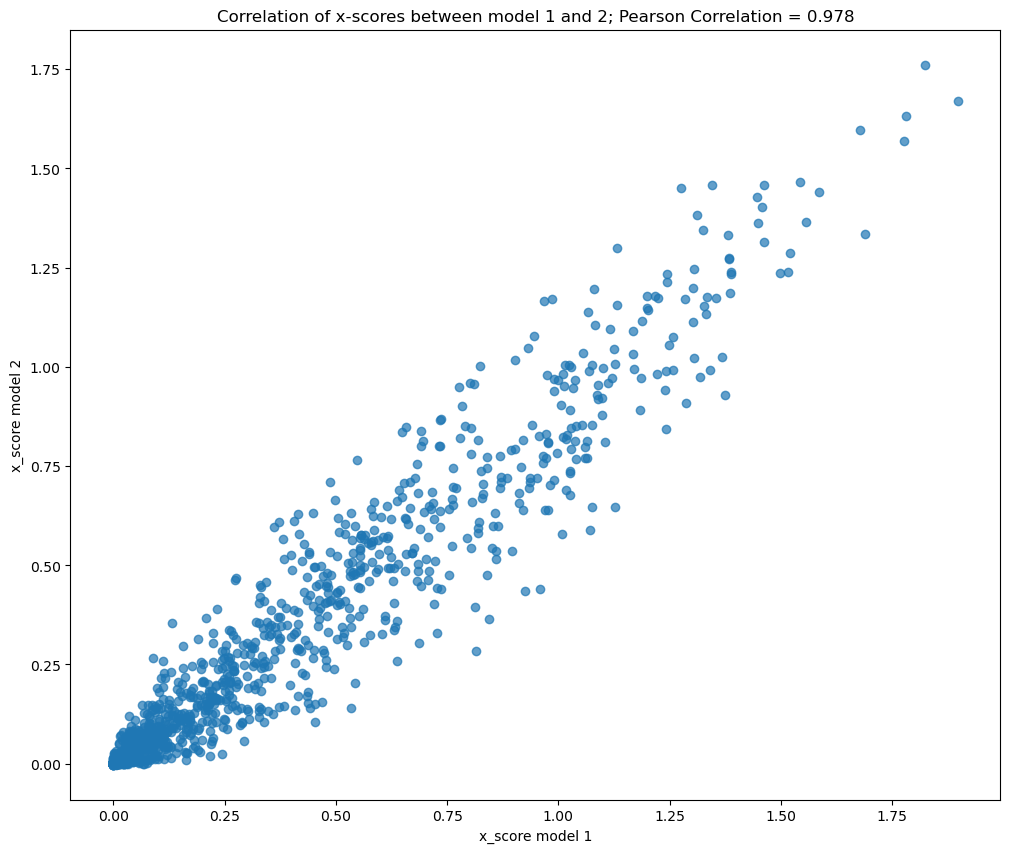

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["x_m1_avg"], summary_df["x_m2_avg"], alpha=0.7)

pearson_corr = stats.pearsonr(summary_df["x_m1_avg"], summary_df["x_m2_avg"]).statistic
rounded_pearson_corr = round(pearson_corr, 3)

ax.set_xlabel("x_score model 1")
ax.set_ylabel("x_score model 2")

ax.set_title(f"Correlation of x-scores between model 1 and 2; Pearson Correlation = {rounded_pearson_corr}")

plt.show()

# Focus on cross-score - correlations between targets

In [36]:
target_indices = [target_index for target_index in range(nr_targets)]
scores_order = list(numpy_arrays_dict[str(model_indices[0])].keys())

In [37]:
target_array = np.zeros((len(scores_order), nr_sites, nr_targets))

for model_index in model_indices:
    print("model: ", model_index)
    
    for score_index in range(len(scores_order)):
        score = scores_order[score_index]
        print("\t- ", score)
    
        for target_index in target_indices:
            column_name = f"{score}_m{model_index}_t{target_index}"
            
            for background_i in background_indices:
                target_array[score_index, :, target_index] += np.array(df[df["background_index"] == background_i][column_name])

            target_array[score_index, :, target_index] = target_array[score_index, :, target_index] / len(background_indices)

target_array = target_array / len(model_indices)


model:  1
	-  boSCD
	-  cross
	-  dot
	-  dotSCD
	-  x
model:  2
	-  boSCD
	-  cross
	-  dot
	-  dotSCD
	-  x


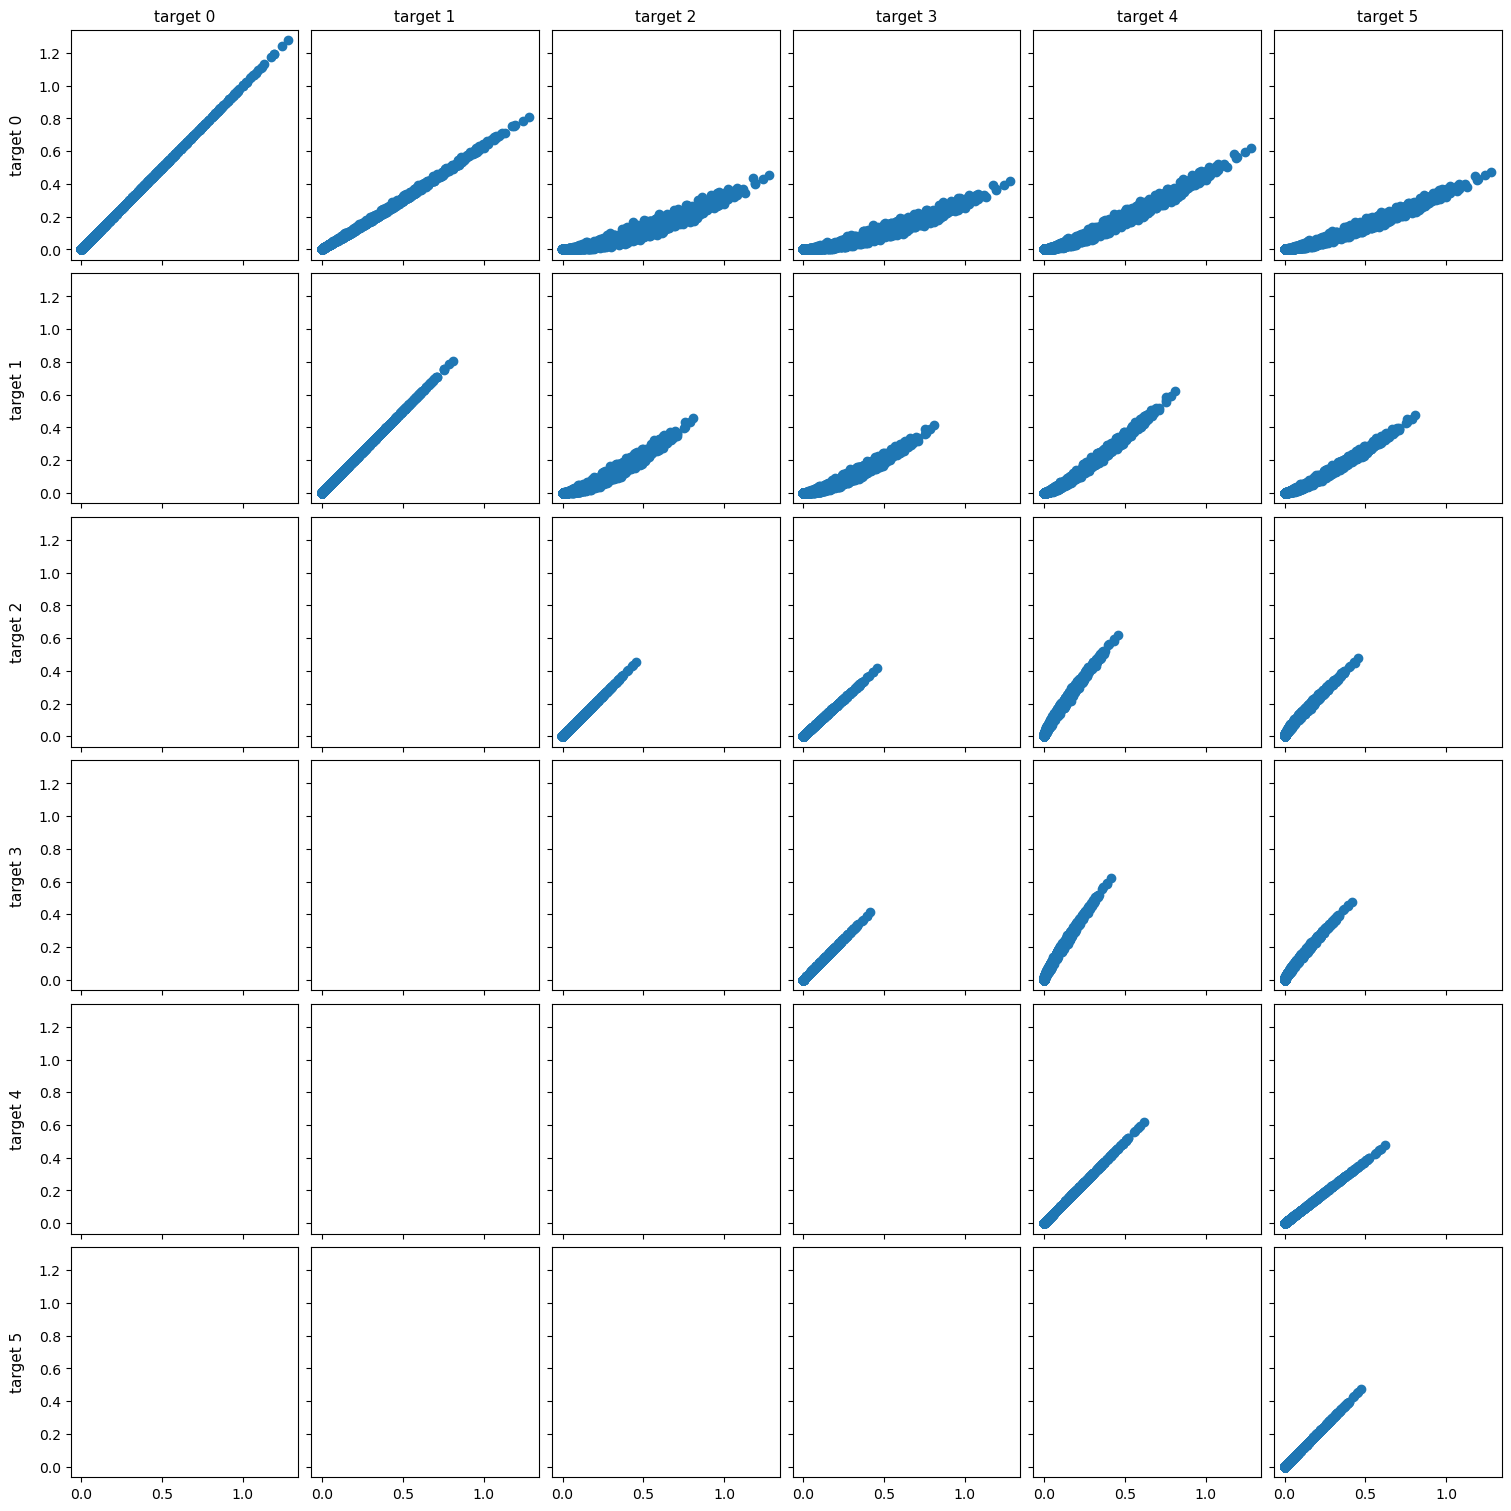

In [38]:
target_corr_array = np.zeros((nr_targets, nr_targets))
score_index = 1 #cross-score

fig, axs = plt.subplots(nr_targets, nr_targets, sharex=True, sharey=True, figsize=(15, 15), layout="constrained")

for target_index_x in target_indices:
    for target_index_y in target_indices:
        if target_index_y >= target_index_x:

            pearson_corr = stats.pearsonr(target_array[score_index, :, target_index_x], target_array[score_index, :, target_index_y]).statistic
            rounded_pearson_corr = round(pearson_corr, 3)
            
            axs[target_index_x, target_index_y].scatter(target_array[score_index, :, target_index_x], target_array[score_index, :, target_index_y])
            target_corr_array[target_index_x, target_index_y] += rounded_pearson_corr

cols = rows = [f"target {target_index}" for target_index in target_indices]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=11)

for ax, row in zip(axs[:, 0],rows,):
    ax.set_ylabel(row, rotation=90, fontsize=11, labelpad=10)
    

In [39]:
target_corr_array

array([[1.   , 0.999, 0.963, 0.966, 0.987, 0.986],
       [0.   , 1.   , 0.971, 0.974, 0.991, 0.991],
       [0.   , 0.   , 1.   , 1.   , 0.994, 0.994],
       [0.   , 0.   , 0.   , 1.   , 0.995, 0.995],
       [0.   , 0.   , 0.   , 0.   , 1.   , 1.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

# Correlations between scores

In [41]:
scores_order

['boSCD', 'cross', 'dot', 'dotSCD', 'x']

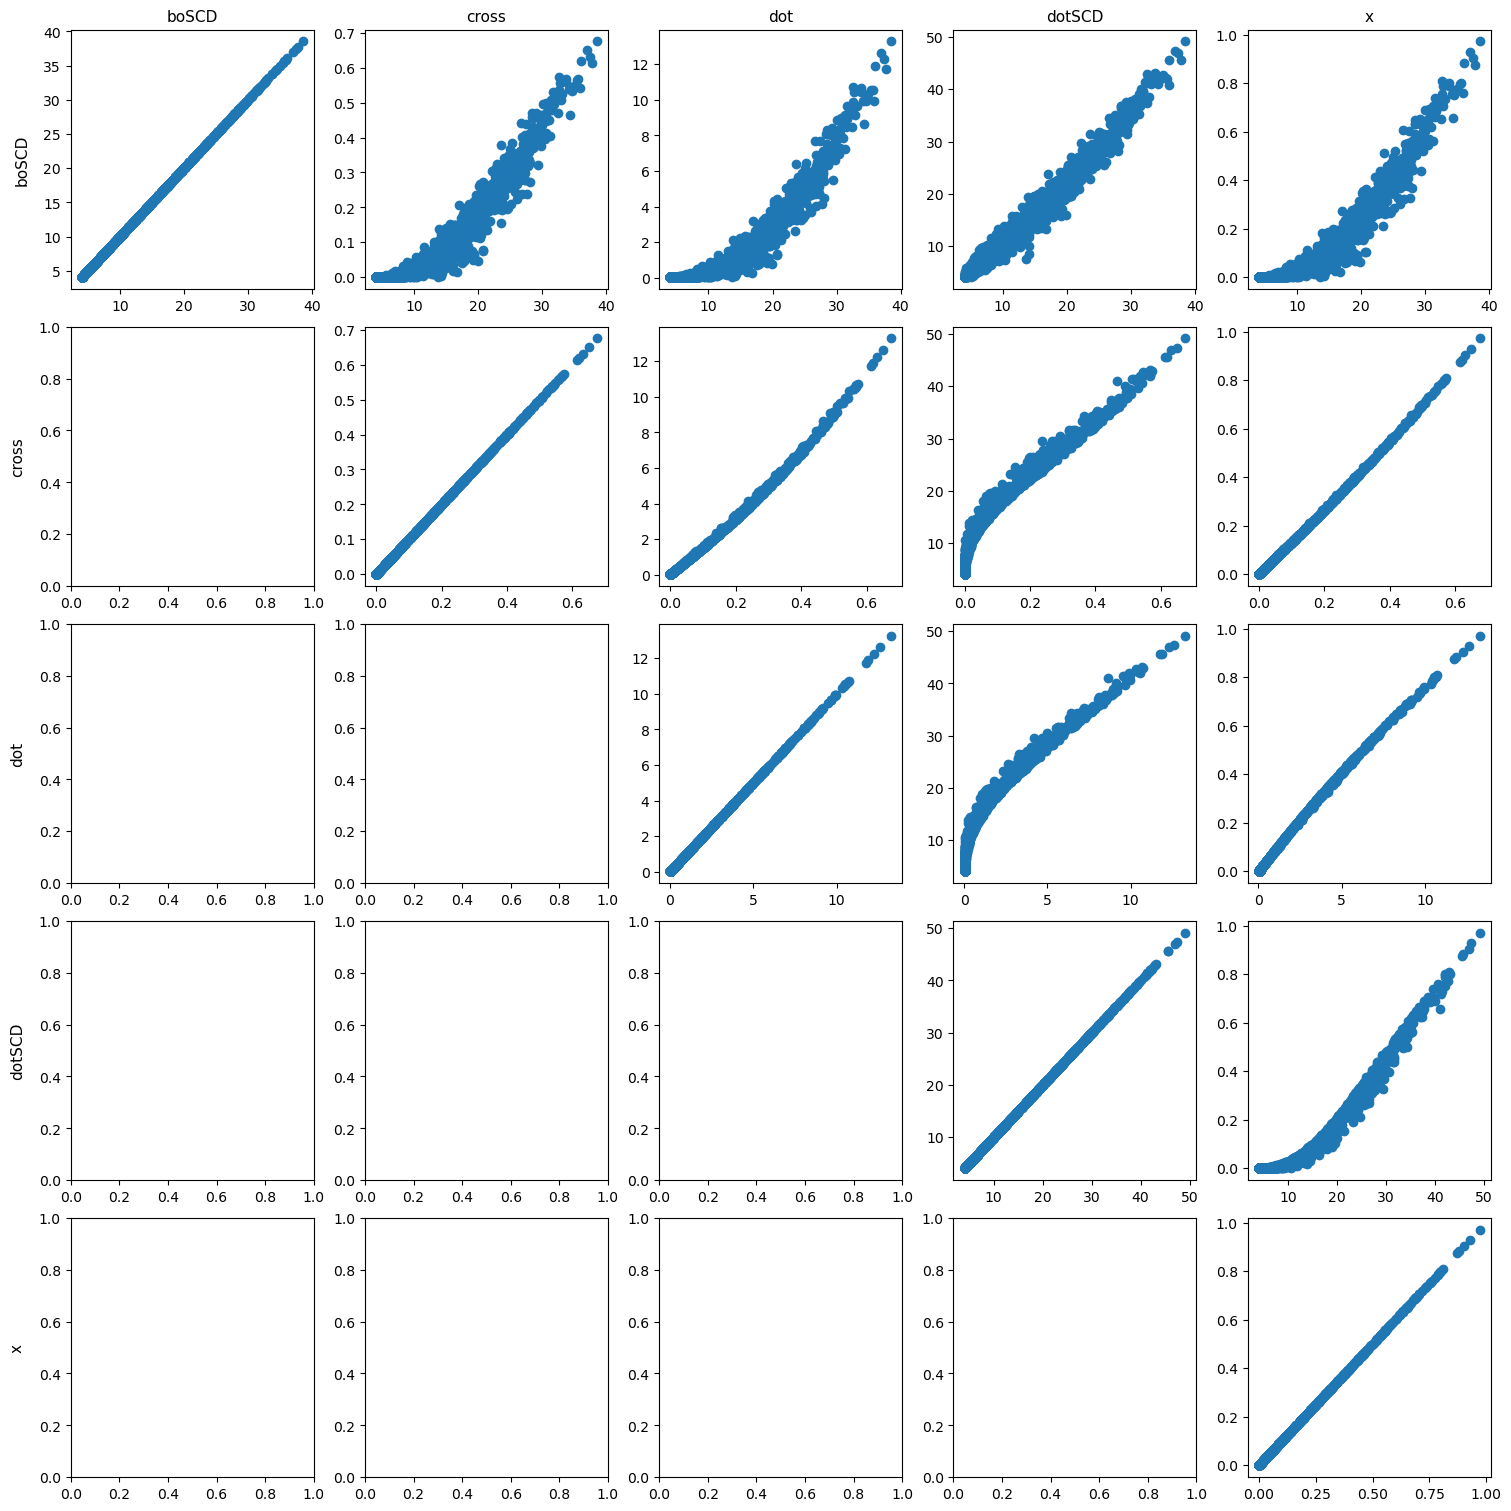

In [51]:
nr_scores = len(scores_order)
core_corr_array = np.zeros((nr_scores, nr_scores))

fig, axs = plt.subplots(nr_scores, nr_scores, figsize=(15, 15), layout="constrained")

for score_index_x in range(nr_scores):
    for score_index_y in range(nr_scores):
        if score_index_y >= score_index_x:

            x = np.mean(target_array[score_index_x, :, :], axis=1)
            y = np.mean(target_array[score_index_y, :, :], axis=1)
            
            pearson_corr = stats.pearsonr(x, y).statistic
            rounded_pearson_corr = round(pearson_corr, 3)
            
            axs[score_index_x, score_index_y].scatter(x, y)
            core_corr_array[score_index_x, score_index_y] += rounded_pearson_corr

cols = rows = [score for score in scores_order]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=11)

for ax, row in zip(axs[:, 0],rows,):
    ax.set_ylabel(row, rotation=90, fontsize=11, labelpad=10)

In [52]:
core_corr_array

array([[1.   , 0.941, 0.923, 0.994, 0.936],
       [0.   , 1.   , 0.997, 0.96 , 1.   ],
       [0.   , 0.   , 1.   , 0.944, 0.999],
       [0.   , 0.   , 0.   , 1.   , 0.956],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

# Picking a random set of points to plot them

In [90]:
sample = [931, 5680, 1111, 7470, 510, 5750, 2000, 11, 5886]

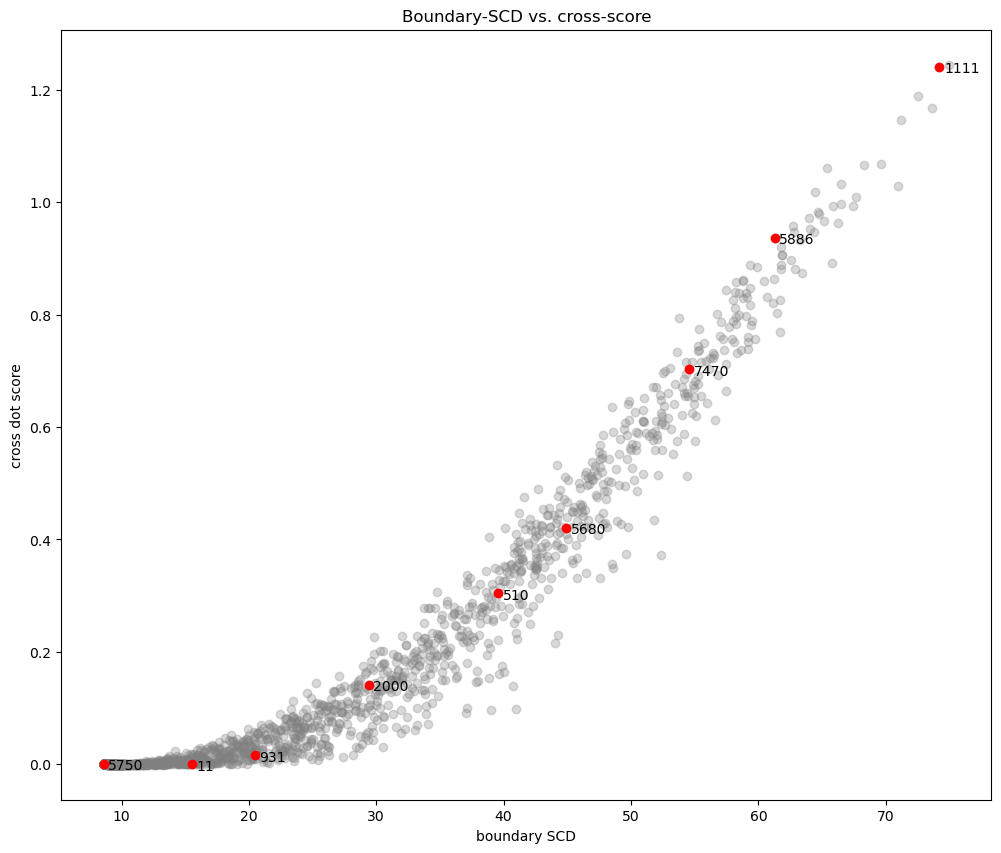

In [91]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(summary_df["boSCD_avg"], summary_df["cross_avg"], c = "gray", alpha=0.3)
scatter = ax.scatter(summary_df["boSCD_avg"].iloc[sample], summary_df["cross_avg"].iloc[sample], c="red")

for sample_id in sample:
    plt.text(summary_df["boSCD_avg"].iloc[sample_id]+0.35, summary_df["cross_avg"].iloc[sample_id]-0.01, summary_df.seq_id.iloc[sample_id], horizontalalignment='left', color='black')

ax.set_xlabel("boundary SCD")
ax.set_ylabel("cross dot score")

ax.set_title("Boundary-SCD vs. cross-score")

plt.show()